In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from ast import literal_eval

import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE

# from bert_serving.client import BertClient

# from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
# from sklear

from keras import layers, models

Using TensorFlow backend.


In [2]:
# bc = BertClient()

In [3]:
PATTERN_IDS = re.compile(r'[.,]')
PATTERN_NAMES = re.compile(r'[,]')

In [4]:
train_info = pd.read_csv('train_info.tsv', sep='\t')
test_info = pd.read_csv('test_info.tsv', sep='\t')
train_rank = pd.read_csv('train_rank.csv')

train_additional_data = pd.read_csv('train_additional_data.csv')
test_additional_data = pd.read_csv('test_additional_data.csv')

In [5]:
train_info.head()

ID                           title artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển   Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa  Minh Tuyết       455   
2  1073835561               Rồi Ánh Trăng Tan    Lưu Bích       450   
3  1073856553  Còn Thương Rau Đắng Mọc Sau Hè   Như Quỳnh       551   
4  1073929630             Người Điên Biết Yêu    Như Loan       513   

  composers_name composers_id         release_time  
0   Châu Đình An         5765  2017-10-01 22:07:00  
1      Trường Sa       100105  2017-10-01 20:58:00  
2       Quốc Bảo         4355  2017-11-01 18:16:00  
3        Bắc Sơn         7686  2017-11-01 17:36:00  
4    Lê Minh Kha       100466  2017-11-01 17:49:00

In [6]:
test_info.head()

ID                    title         artist_name  artist_id  \
0  1073994292          Giấc Mơ Mình Em          Minh Tuyết        455   
1  1074250503           Rồi 30 Năm Qua            Tâm Đoan        518   
2  1074254709         Hòa Bình Hoan Ca  Hùng Phú, Duy Linh  18241.918   
3  1074254735         Chia Tay Ngày Hè         Xuân Trường      11740   
4  1074326411  Xin Gọi Nhau Là Cố Nhân            Quang Lê        828   

  composers_name composers_id         release_time  
0        Minh Vy       100019  2017-11-01 18:27:00  
1      Nhật Ngân       100218  2017-10-01 22:07:00  
2       Huy Liêu       430572  2017-11-07 23:47:00  
3       Huy Liêu       430572  2017-11-07 23:38:00  
4      Song Ngọc       100288  2017-10-01 21:33:00

In [7]:
train_rank.head()

ID  label
0  1073748245      7
1  1073751978      3
2  1073835561      6
3  1073856553      2
4  1073929630      7

# 1. Explore data:
- ID has type int
- All other columns have type object, but artist_id and composer_id can be of type int
- There is no null values

## 1.1. Info data

In [8]:
train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 7 columns):
ID                9078 non-null int64
title             9078 non-null object
artist_name       9078 non-null object
artist_id         9078 non-null object
composers_name    9078 non-null object
composers_id      9078 non-null object
release_time      9078 non-null object
dtypes: int64(1), object(6)
memory usage: 496.5+ KB


In [9]:
train_info.iloc[:, 1:].describe()

title       artist_name artist_id       composers_name  \
count               9078              9078      9078                 9078   
unique              6766              2397      2391                 2048   
top     Đắp Mộ Cuộc Tình  Hoàng Minh Thắng    601427  Nhạc Ngoại Lời Việt   
freq                  33               147       147                  178   

       composers_id         release_time  
count          9078                 9078  
unique         2212                 3675  
top          100103  2018-11-14 21:38:00  
freq            178                   26

In [10]:
# check if ID column contains all unique value
assert len(train_info.ID.unique()) == len(train_info)

In [11]:
test_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 7 columns):
ID                1118 non-null int64
title             1118 non-null object
artist_name       1118 non-null object
artist_id         1118 non-null object
composers_name    1118 non-null object
composers_id      1118 non-null object
release_time      1118 non-null object
dtypes: int64(1), object(6)
memory usage: 61.2+ KB


In [12]:
test_info.iloc[:, 1:].describe()

title       artist_name artist_id       composers_name  \
count                 1118              1118      1118                 1118   
unique                1036               677       675                  587   
top     Câu Chuyện Đầu Năm  Hoàng Minh Thắng    601427  Nhạc Ngoại Lời Việt   
freq                     5                20        20                   28   

       composers_id         release_time  
count          1118                 1118  
unique          614                  860  
top          100103  2017-10-01 22:20:00  
freq             28                    6

In [13]:
assert len(test_info.ID.unique()) == len(test_info)

In [14]:
# # extract data by each rank
# for i in range(1, 11):
#     train_info_rank[train_info_rank.label==i].to_csv('extracted_data/train_info_rank_'+str(i)+'.csv', index=False)

## 1.2. Rank data:

In [15]:
train_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 2 columns):
ID       9078 non-null int64
label    9078 non-null int64
dtypes: int64(2)
memory usage: 141.9 KB


In [16]:
# check if train rank id column is the same as that of train_info
assert (train_rank.ID.sort_values() - train_info.ID.sort_values()).sum() == 0

- So it is true that 2 dataframes' ID columns are the same

In [17]:
train_rank.label.value_counts()

10    932
6     920
1     916
7     913
3     910
9     909
2     905
8     902
4     895
5     876
Name: label, dtype: int64

- Pretty good, there is no large imbalance in distribution of the label class

## 1.3. Concatenate train data with label

In [18]:
train_info_rank = pd.merge(left=train_info, right=train_rank, on='ID')
# train_info_rank = pd.merge(left=train_info_rank, right=train_additional_data, on='ID', how='left')

In [19]:
# test_info = pd.merge(left=test_info, right=test_additional_data, on='ID', how='left')

In [20]:
train_info_rank.head()

ID                           title artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển   Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa  Minh Tuyết       455   
2  1073835561               Rồi Ánh Trăng Tan    Lưu Bích       450   
3  1073856553  Còn Thương Rau Đắng Mọc Sau Hè   Như Quỳnh       551   
4  1073929630             Người Điên Biết Yêu    Như Loan       513   

  composers_name composers_id         release_time  label  
0   Châu Đình An         5765  2017-10-01 22:07:00      7  
1      Trường Sa       100105  2017-10-01 20:58:00      3  
2       Quốc Bảo         4355  2017-11-01 18:16:00      6  
3        Bắc Sơn         7686  2017-11-01 17:36:00      2  
4    Lê Minh Kha       100466  2017-11-01 17:49:00      7

- There are some song appears more than once, at most 33 song

In [21]:
train_info_rank.groupby('title')['ID'].count().sort_values(ascending=False)

title
Đắp Mộ Cuộc Tình                      33
Lại Nhớ Người Yêu                     29
Đoạn Tuyệt                            29
Con Đường Xưa Em Đi                   27
Cát Bụi Cuộc Đời                      22
Người Tình Không Đến                  19
Đêm Tâm Sự                            19
Hoa Nở Về Đêm                         16
Câu Chuyện Đầu Năm                    16
Duyên Phận                            16
Mùa Xuân Xa Quê                       14
Nối Lại Tình Xưa                      13
Sương Lạnh Chiều Đông                 13
Phố Đêm                               13
Vùng Lá Me Bay                        13
Hãy Quên Anh                          13
Chuyến Tàu Hoàng Hôn                  12
Đoạn Buồn Đêm Mưa                     12
Nỗi Buồn Mẹ Tôi                       12
Hồi Tưởng                             12
Hoa Trinh Nữ                          12
Cõi Nhớ                               12
Nhớ Nhau Hoài                         11
Đêm Giao Thừa Nghe Một Khúc Dân Ca    11
Chuyến Đò 

- Why artist_id and artist_name have different unique values? (If 1 artist is assigned 1 unique id so the number of unique values in artist_name column and artist_id column are expected to be the same)
- Number of unique artist_id < number of unique artist_name -> 2 different artist names have the same artist_id

In [22]:
print('Number of unique artist_id in train set: ', len(train_info_rank.artist_id.unique()))
print('Number of unique artist_name in train set: ', len(train_info_rank.artist_name.unique()))

Number of unique artist_id in train set:  2391
Number of unique artist_name in train set:  2397


In [23]:
print('Number of unique artist_id in test set: ', len(test_info.artist_id.unique()))
print('Number of unique artist_name in test set: ', len(test_info.artist_name.unique()))

Number of unique artist_id in test set:  675
Number of unique artist_name in test set:  677


In [24]:
# group by artist_id and count unique artist_name in each group
train_info_rank.groupby(['artist_id'])['artist_name'].agg(lambda x: len(x.unique())).sort_values(ascending=False)

artist_id
53227                   2
434619                  2
434312                  2
64965                   2
35271                   2
47562                   2
434865                  2
55617                   2
270207                  2
602181                  2
432475                  2
73069                   2
73045                   2
105117                  2
10482                   2
431569                  2
609567                  2
16732                   2
431403                  2
72572                   2
427597                  1
427649                  1
427649.431147           1
427680                  1
427595                  1
427680.44896            1
4288                    1
427761,433607,434859    1
427840                  1
427840.432161           1
                       ..
605072                  1
605048.605049           1
605048,605049,605878    1
605022.68663            1
605022                  1
605020.616027           1
605020                  1
60

In [25]:
train_info_rank[train_info_rank.artist_id == '434619']

ID                                   title    artist_name  \
2368  1076447542                        Ân Tình Đổi Thay          Như Ý   
2369  1076447543                 Ân Tình Đổi Thay (Beat)          Như Ý   
6946  1078196228  Tình Phôi Phai (Dân Ca Version) (Beat)  Brianna Như Ý   
6947  1078196229         Tình Phôi Phai (Dân Ca Version)  Brianna Như Ý   
8031  1078245272                Bài Tango Cho Người Tình  Brianna Như Ý   
8287  1078283936     Tình Phôi Phai (EDM Version) (Beat)  Brianna Như Ý   

     artist_id composers_name composers_id         release_time  label  
2368    434619       Tăng Nga       103806  2017-11-28 21:42:00      6  
2369    434619       Tăng Nga       103806  2017-11-28 21:42:00      9  
6946    434619       Tăng Nga       103806  2018-08-13 21:47:00      8  
6947    434619       Tăng Nga       103806  2018-08-13 21:47:00      7  
8031    434619       Tăng Nga       103806  2018-08-11 04:11:00      7  
8287    434619       Tăng Nga       103806  2018-10-30 18:30:00      9

- The above example show a case where 1 artist_id corresponds to 2 artist_name: 'Như Ý' and 'Brianna Như Ý'

## Some song having multiple artists or composers

### Artists count

In [26]:
# create new columns: n_artists, n_composers
train_info_rank['n_artist_ids'] = train_info_rank['artist_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
train_info_rank['n_artist_names'] = train_info_rank['artist_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

- There are some cases that artist ids count and artist names count don't match because of values in artist_id (having no split patterns like (.) or (,))

In [27]:
train_info_rank[train_info_rank.n_artist_ids != train_info_rank.n_artist_names]

ID                                              title  \
122   1075810973                              Tiếng Hát Từ Nhịp Tim   
128   1075810991                                 Hương Đồng Gió Nội   
129   1075810992                                 Hương Đồng Gió Nội   
1233  1076376658                     Con Gái Của Mẹ - Làm Dâu Xứ Lạ   
8952  1078442172  Liên Khúc Bay Đi Cánh Chim Biển - Hẹn Hò - Tìn...   
8954  1078442174                           Liên Khúc Khúc Tình Buồn   

                                            artist_name        artist_id  \
122   Rebecca Quỳnh Giao, Như Loan, Tú Quyên, Loan Châu  107963513562827   
128                       Bảo Hân, Như Loan, Hương Thủy        855513870   
129                       Bảo Hân, Như Loan, Hương Thủy        855513870   
1233                    Hồng Gấm, Phi Nhung, Mạnh Quỳnh     105258374451   
8952      Thu Phương, Bằng Kiều, Ngọc Hạ, Trần Thái Hòa     900306931901   
8954                Thu Phương, Trần Thái Hòa, Thanh Hà        900901493   

                        composers_name          composers_id  \
122               Tùng Châu, Nhật Ngân         100739.100218   
128                          Song Ngọc                100288   
129                          Song Ngọc                100288   
1233                     Nhiều Tác Giả                101740   
8952  Đức Huy, Phạm Duy, Ngô Thụy Miên  100057,100109,100026   
8954          Phạm Duy, Lê Uyên Phương         100109.100108   

             release_time  label  n_artist_ids  n_artist_names  
122   2017-10-01 21:22:00      8             1               4  
128   2017-10-01 21:33:00      8             1               3  
129   2017-10-01 21:33:00     10             1               3  
1233  2017-11-09 22:30:00      1             1               3  
8952  2018-12-21 01:27:00      4             1               4  
8954  2018-12-21 01:27:00      3             1               3

- These abnormally long ids are the concatenation of multiple ids

### Composers count

In [28]:
train_info_rank['n_composer_ids'] = train_info_rank['composers_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
train_info_rank['n_composer_names'] = train_info_rank['composers_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

- Count of composer ids and composer names match

In [29]:
train_info_rank[train_info_rank.n_composer_ids != train_info_rank.n_composer_names]

Empty DataFrame
Columns: [ID, title, artist_name, artist_id, composers_name, composers_id, release_time, label, n_artist_ids, n_artist_names, n_composer_ids, n_composer_names]
Index: []

### Test artist and composer count

In [30]:
test_info['n_artist_ids'] = test_info['artist_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
test_info['n_artist_names'] = test_info['artist_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [31]:
test_info[test_info.n_artist_ids != test_info.n_artist_names]

Empty DataFrame
Columns: [ID, title, artist_name, artist_id, composers_name, composers_id, release_time, n_artist_ids, n_artist_names]
Index: []

In [32]:
test_info['n_composer_ids'] = test_info['composers_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
test_info['n_composer_names'] = test_info['composers_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [33]:
test_info[test_info.n_composer_ids != test_info.n_composer_names]

ID               title   artist_name artist_id  \
364  1078014543  Xuân Này Con Sẽ Về  Lưu Thiên Ân     64833   

                 composers_name composers_id         release_time  \
364  Hoài An, Trang Dũng Phương       103442  2018-04-01 16:30:00   

     n_artist_ids  n_artist_names  n_composer_ids  n_composer_names  
364             1               1               1                 2

In [34]:
# test_info.drop('n_composer_ids', axis=1, inplace=True)

## Some correlation of features with the label

### artist_id

In [35]:
print('Number of unique artist ids in train set: ', len(train_info_rank.artist_id.unique()))

Number of unique artist ids in train set:  2391


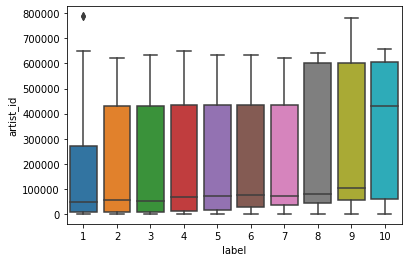

In [36]:
a = train_info_rank[['label', 'artist_id']].loc[train_info_rank.n_artist_names == 1].astype(int)
sns.boxplot(data=a, x='label', y='artist_id')

### composer id

In [37]:
print('Number of unique composer ids in train set: ', len(train_info_rank.composers_id.unique()))

Number of unique composer ids in train set:  2212


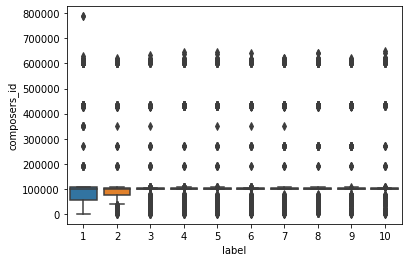

In [38]:
a = train_info_rank[['label', 'composers_id']].loc[train_info_rank.n_composer_names == 1].astype(int)
sns.boxplot(data=a, x='label', y='composers_id')

### Check the intersection of values in each column of train_info and test_info

- No intersection of ID column between train_info and test_info

In [39]:
set(train_info.ID).intersection(set(test_info.ID))

set()

In [40]:
def count_intersection(col_name):
    print('Number of mutual values between train_info %s column and test_info %s column:'%(col_name, col_name))
    print(len(set(train_info[col_name]).intersection(set(test_info[col_name]))))

In [41]:
print('Number of unique artist_id in train_set:', len(train_info_rank.artist_id.unique()))
print('Number of unique artist_id in test_set:', len(test_info.artist_id.unique()))

print('Number of unique artist_name in train_set:', len(train_info_rank.artist_name.unique()))
print('Number of unique artist_name in test_set:', len(test_info.artist_name.unique()))

Number of unique artist_id in train_set: 2391
Number of unique artist_id in test_set: 675
Number of unique artist_name in train_set: 2397
Number of unique artist_name in test_set: 677


In [42]:
count_intersection('artist_id')
count_intersection('artist_name')
count_intersection('composers_id')
count_intersection('composers_name')

Number of mutual values between train_info artist_id column and test_info artist_id column:
519
Number of mutual values between train_info artist_name column and test_info artist_name column:
519
Number of mutual values between train_info composers_id column and test_info composers_id column:
484
Number of mutual values between train_info composers_name column and test_info composers_name column:
467


In [43]:
# song_count_each_rank.head()

### n_months_counts:
count number of month from released time to now

In [44]:
def months_between(date1,date2):
    if date1>date2:
        date1,date2=date2,date1
    m1=date1.year*12+date1.month
    m2=date2.year*12+date2.month
    months=m2-m1
    if date1.day>date2.day:
        months-=1
    elif date1.day==date2.day:
        seconds1=date1.hour*3600+date1.minute+date1.second
        seconds2=date2.hour*3600+date2.minute+date2.second
        if seconds1>seconds2:
            months-=1
    return months

In [45]:
months_between(datetime.datetime.now(), pd.to_datetime(train_info_rank.release_time).iloc[4])

23

In [46]:
train_info_rank['release_time'] = pd.to_datetime(train_info_rank.release_time)
last_date = train_info_rank['release_time'].max()
print(last_date)
# train_info_rank['n_month_counts'] = train_info_rank.release_time - last_date
train_info_rank['n_month_counts'] = train_info_rank.release_time.map(lambda x: months_between(last_date, x))

2018-12-31 22:32:00


In [47]:
train_info_rank['n_month_counts'] = train_info_rank.release_time.map(lambda x: months_between(last_date, x))

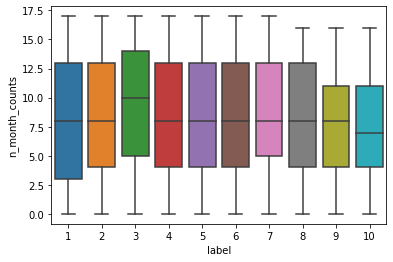

In [48]:
sns.boxplot(data=train_info_rank, x='label', y='n_month_counts')

In [49]:
del train_info_rank['n_month_counts']

## Title feature engineering:
- Get k most frequent words
- Generate k features denote whether a song title contains these words or not

In [50]:
all_titles = pd.concat([train_info_rank.title, test_info.title])
ptn = re.compile(r'[ ./()]')
title_word = pd.Series(re.split(ptn, all_titles.str.lower().str.cat(sep=' ')))

In [51]:
k = 8
k_mode_words = title_word[title_word != ''].value_counts().index.values[:k]
k_mode_words

array(['em', 'tình', 'beat', 'anh', 'yêu', 'người', 'remix', 'xuân'],
      dtype=object)

In [52]:
# title_word.value_counts()

In [53]:
for word in k_mode_words:
    train_info_rank[word] = train_info_rank.title.map(lambda x: word in x.lower()).astype(int)
    test_info[word] = test_info.title.map(lambda x: word in x.lower()).astype(int)


## Title count:
- Generate a new features denote how many times a song title appear in training set

In [54]:
title_count = all_titles.value_counts().reset_index()
title_count.columns = ['title', 'title_count']
title_count

title  title_count
0                                      Đắp Mộ Cuộc Tình           35
1                                     Lại Nhớ Người Yêu           33
2                                            Đoạn Tuyệt           32
3                                   Con Đường Xưa Em Đi           27
4                                      Cát Bụi Cuộc Đời           25
5                                            Đêm Tâm Sự           22
6                                    Câu Chuyện Đầu Năm           21
7                                  Người Tình Không Đến           19
8                                         Hoa Nở Về Đêm           18
9                                            Duyên Phận           17
10                                         Hoa Trinh Nữ           15
11                                       Vùng Lá Me Bay           15
12                                Sương Lạnh Chiều Đông           15
13                                     Nối Lại Tình Xưa           14
14                                         Hãy Quên Anh           14
15                                      Mùa Xuân Xa Quê           14
16                                              Phố Đêm           14
17                                       Thành Phố Buồn           13
18                                   Chuyến Đò Không Em           13
19                            Chuyện Tình Không Dĩ Vãng           13
20                                      Cho Vừa Lòng Em           13
21                                    Đoạn Buồn Đêm Mưa           12
22                              Nếu Được Làm Người Tình           12
23                   Đêm Giao Thừa Nghe Một Khúc Dân Ca           12
24                                        Vu Lan Nhớ Mẹ           12
25                                                   Mẹ           12
26                                               Mẹ Tôi           12
27                                              Cõi Nhớ           12
28                                         Yêu Một Mình           12
29                                 Chuyến Tàu Hoàng Hôn           12
...                                                 ...          ...
7455                                         Sad Sunday            1
7456                                    Từ Khi Vắng Anh            1
7457                           Cố Chấp Để Yêu Một Người            1
7458                             Khi Người Đàn Ông Khóc            1
7459                                   Tôi Đã Yêu Người            1
7460                      Hóa Ra Tình Yêu Là Thế (Beat)            1
7461                            Ân Cha Mẹ Như Trời Biển            1
7462                                Ánh Mắt Buồn (Beat)            1
7463                                     Ký Ức Đêm Noel            1
7464     Sấp Mặt Luôn (Tấm Cám Chuyện Huỳnh Lập Kể OST)            1
7465                            Người Ta Và Anh (Remix)            1
7466                     Mỗi Ngày Tôi Chọn Một Niềm Vui            1
7467                                 Chìa Khóa Tình Yêu            1
7468  Thương Nhớ Người Yêu (Nhớ Người Yêu 2) (Beat Nam)            1
7469                                  Hai Mươi Bốn Mươi            1
7470                                   Giấc Mơ Tuổi Thơ            1
7471                             Người Con Gái Việt Nam            1
7472                                          Cái Duyên            1
7473                     Thương Về Khúc Ruột Miền Trung            1
7474                                   Hôm Nay Tôi Buồn            1
7475                                     Tâm Sự Với Con            1
7476                                     Anh Lầm (Beat)            1
7477                                          Bỏ Anh Đi            1
7478                               Thênh Thang Mùa Xuân            1
7479                        Tại Sao Em Phải Khóc (Beat)            1
7480                                                Túy            1
7481                                     Come Ba

In [55]:
train_info_rank = pd.merge(left=train_info_rank, right=title_count, on='title', how='inner')
test_info = pd.merge(left=test_info, right=title_count, on='title', how='inner')

In [56]:
train_info_rank.head()

ID                           title  artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển    Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa   Minh Tuyết       455   
2  1076456879               Mùa Thu Trong Mưa  Quang Thắng    432303   
3  1073835561               Rồi Ánh Trăng Tan     Lưu Bích       450   
4  1073856553  Còn Thương Rau Đắng Mọc Sau Hè    Như Quỳnh       551   

  composers_name composers_id        release_time  label  n_artist_ids  \
0   Châu Đình An         5765 2017-10-01 22:07:00      7             1   
1      Trường Sa       100105 2017-10-01 20:58:00      3             1   
2      Trường Sa       100105 2017-08-13 01:30:00      9             1   
3       Quốc Bảo         4355 2017-11-01 18:16:00      6             1   
4        Bắc Sơn         7686 2017-11-01 17:36:00      2             1   

   n_artist_names  ...  n_composer_names  em  tình  beat  anh  yêu  người  \
0               1  ...                 1   0     0     0    0    0      0   
1               1  ...                 1   0     0     0    0    0      0   
2               1  ...                 1   0     0     0    0    0      0   
3               1  ...                 1   0     0     0    0    0      0   
4               1  ...                 1   0     0     0    0    0      0   

   remix  xuân  title_count  
0      0     0            1  
1      0     0            2  
2      0     0            2  
3      0     0            1  
4      0     0            8  

[5 rows x 21 columns]

In [57]:
test_info.head()

ID                    title         artist_name  artist_id  \
0  1073994292          Giấc Mơ Mình Em          Minh Tuyết        455   
1  1074250503           Rồi 30 Năm Qua            Tâm Đoan        518   
2  1074254709         Hòa Bình Hoan Ca  Hùng Phú, Duy Linh  18241.918   
3  1074254735         Chia Tay Ngày Hè         Xuân Trường      11740   
4  1074326411  Xin Gọi Nhau Là Cố Nhân            Quang Lê        828   

  composers_name composers_id         release_time  n_artist_ids  \
0        Minh Vy       100019  2017-11-01 18:27:00             1   
1      Nhật Ngân       100218  2017-10-01 22:07:00             1   
2       Huy Liêu       430572  2017-11-07 23:47:00             2   
3       Huy Liêu       430572  2017-11-07 23:38:00             1   
4      Song Ngọc       100288  2017-10-01 21:33:00             1   

   n_artist_names  n_composer_ids  n_composer_names  em  tình  beat  anh  yêu  \
0               1               1                 1   1     0     0    0    0   
1               1               1                 1   0     0     0    0    0   
2               2               1                 1   0     0     0    0    0   
3               1               1                 1   0     0     0    0    0   
4               1               1                 1   0     0     0    0    0   

   người  remix  xuân  title_count  
0      0      0     0            1  
1      0      0     0            1  
2      0      0     0            1  
3      0      0     0            1  
4      0      0     0           10

## 1.4. Additional data:
- Additional data is derived from ID3 tags of mp3 files
- Some features: genre, album, track_num, ...

In [58]:
train_info_rank = pd.merge(left=train_info_rank, right=train_additional_data, on='ID', how='left')
test_info = pd.merge(left=test_info, right=test_additional_data, on='ID', how='left')

In [59]:
train_info_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 48 columns):
ID                       9078 non-null int64
title                    9078 non-null object
artist_name              9078 non-null object
artist_id                9078 non-null object
composers_name           9078 non-null object
composers_id             9078 non-null object
release_time             9078 non-null datetime64[ns]
label                    9078 non-null int64
n_artist_ids             9078 non-null int64
n_artist_names           9078 non-null int64
n_composer_ids           9078 non-null int64
n_composer_names         9078 non-null int64
em                       9078 non-null int64
tình                     9078 non-null int64
beat                     9078 non-null int64
anh                      9078 non-null int64
yêu                      9078 non-null int64
người                    9078 non-null int64
remix                    9078 non-null int64
xuân                    

### Drop all NaN columns

In [60]:
nan_portion = train_info_rank.isnull().mean()
nan_columns = nan_portion[nan_portion == 1.0].index.values
train_info_rank.drop(nan_columns, axis=1, inplace=True)

### Drop columns with only 1 value

In [61]:
for col in train_info_rank.columns:
    if(len(train_info_rank[col].dropna().unique()) == 1):
        train_info_rank.drop(col, axis=1, inplace=True)

In [62]:
train_info_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 33 columns):
ID                   9078 non-null int64
title                9078 non-null object
artist_name          9078 non-null object
artist_id            9078 non-null object
composers_name       9078 non-null object
composers_id         9078 non-null object
release_time         9078 non-null datetime64[ns]
label                9078 non-null int64
n_artist_ids         9078 non-null int64
n_artist_names       9078 non-null int64
n_composer_ids       9078 non-null int64
n_composer_names     9078 non-null int64
em                   9078 non-null int64
tình                 9078 non-null int64
beat                 9078 non-null int64
anh                  9078 non-null int64
yêu                  9078 non-null int64
người                9078 non-null int64
remix                9078 non-null int64
xuân                 9078 non-null int64
title_count          9078 non-null int64
artist            

### artist (additional data):

- 93% artist_name in train_info.csv match artist feature in additional data

In [63]:
(train_info_rank['artist_name'] == train_info_rank['artist']).mean()

0.9387530293016083

In [64]:
train_info_rank[train_info_rank['artist_name'] != train_info_rank['artist']][['artist_name', 'artist']]

artist_name  \
98                          Hoàng Nhật Thái, Quỳnh Trâm   
136                             Lâm Bảo Phi, Giáng Tiên   
143                                  Nam Em, Mạnh Quỳnh   
144                                  Nam Em, Mạnh Quỳnh   
149                                      Lâm Hoài Phong   
154                                           Diễm Xuân   
181                                        Lưu Ánh Loan   
198                                          Ngọc Khang   
224                       Bảo Hân, Như Loan, Hương Thủy   
289                                      Bảo Hân Bolero   
341                               Thùy Dương, Diễm Xuân   
363   Như Quỳnh, Hương Thủy, Mai Thiên Vân, Phi Nhun...   
381                                  Bằng Kiều, Lam Anh   
407                                   Hollie Thanh Ngọc   
438                          Thu Hồng Bolero, Tiến Vinh   
441                                         Lê Hồng Yến   
456                                         Thanh Cường   
457                                         Thanh Cường   
458                                         Thanh Cường   
485                          Hoàng Minh Sang, Minh Luân   
488                                      Lâm Hoài Phong   
522                          Hoàng Nhật Thái, Ngọc Thảo   
538                        Hoàng Nhật Thái, Phương Thảo   
546                  Chí Thiện, Bé Bảo An, Bé Thụy Bình   
558                                           P336 Band   
577                                            Hoài Nam   
598                                           Diễm Xuân   
602                              Gia Lạc, Trương Cẩm Tú   
604                      Lâm Mạnh Quỳnh, Lâm Thúy Quỳnh   
607                      Thúy Hằng HaNa, Cao Hoàng Nghi   
...                                                 ...   
8504                                        Lý Thu Thảo   
8507                                     Huy Lê, NamKun   
8552                                    Nguyễn Bảo Linh   
8568                                      Hana Phan Hân   
8581                                   Siêu Thịnh, RiuT   
8617                                 Chung NG, Fly High   
8662                                          Hạnh Sino   
8668                               Đàm Vĩnh Hưng, Karik   
8711                                    Đức Phúc, Monta   
8713                                     LyLy, Magazine   
8714                          Ngô Trường, DJ Phơ Nguyễn   
8726                                    Judian, Haohinh   
8730                            Nhật Thành, Hà Duy Thái   
8756                          Hiderway, Daeron, Huy Vạc   
8761                                      Hana Phan Hân   
8762                                      Hana Phan Hân   
8781                                    Nguyễn Bảo Linh   
8879                                CM1X, Yun, Đình Thọ   
8883                                    MAEKO, Marutron   
8888                             Lil Shady, Zenky, Diby   
8889                   Lil Shady, Zenky, BooDi, N’Small   
8890                                   Lil Shady, BooDi   
8923                              Lemese, August, Anngo   
8995                                    Hoàng Hồng Ngọc   
8998                              Khởi My, Jarvis Huỳnh   
9012                                         PI.NO Phạm   
9017                                  Billy Hoàng Phong   
9018                                  Billy Hoàng Phong   
9026                                     K-ICM, Ngọc Vũ   
9037                                            Mr Hero   

                                                 artist  
98                                      Hoàng Nhật Thái  
136                                         Lâm Bảo Phi  
143                                              Nam Em  
144                                              Nam Em  
149                                          Hoài Phong  
154                                  

In [65]:
train_info_rank['artist_match'] = (train_info_rank['artist_name'] == train_info_rank['artist']).astype(int)
test_info['artist_match'] = (test_info['artist_name'] == test_info['artist']).astype(int)

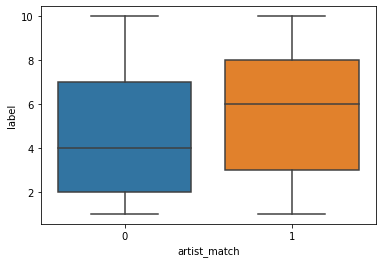

In [66]:
sns.boxplot(data=train_info_rank, x='artist_match', y='label')

### track_num

In [67]:
type(literal_eval('(0, 0)'))

tuple

In [68]:
re.compile('[ (),]').split('(0, 0)')

['', '0', '', '0', '']

In [69]:
track_num = train_info_rank.track_num.replace('(None, None)', '(0, 0)')
track_num = track_num.fillna('(0, 0)')
train_info_rank['track_num_1'] = track_num.map(lambda x: literal_eval(x)[0])
train_info_rank['track_num_2'] = track_num.map(lambda x: literal_eval(x)[1])

track_num = test_info.track_num.replace('(None, None)', '(0, 0)')
track_num = track_num.fillna('(0, 0)')
test_info['track_num_1'] = track_num.map(lambda x: literal_eval(x)[0])
test_info['track_num_2'] = track_num.map(lambda x: literal_eval(x)[1])

In [70]:
train_info_rank.head()

ID                           title  artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển    Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa   Minh Tuyết       455   
2  1076456879               Mùa Thu Trong Mưa  Quang Thắng    432303   
3  1073835561               Rồi Ánh Trăng Tan     Lưu Bích       450   
4  1073856553  Còn Thương Rau Đắng Mọc Sau Hè    Như Quỳnh       551   

  composers_name composers_id        release_time  label  n_artist_ids  \
0   Châu Đình An         5765 2017-10-01 22:07:00      7             1   
1      Trường Sa       100105 2017-10-01 20:58:00      3             1   
2      Trường Sa       100105 2017-08-13 01:30:00      9             1   
3       Quốc Bảo         4355 2017-11-01 18:16:00      6             1   
4        Bắc Sơn         7686 2017-11-01 17:36:00      2             1   

   n_artist_names  ...              genre  \
0               1  ...      Nhạc Trữ Tình   
1               1  ...      Nhạc Trữ Tình   
2               1  ...  Trữ Tình & Bolero   
3               1  ...           Nhạc Trẻ   
4               1  ...      Nhạc Trữ Tình   

                                              lyrics  best_release_date  \
0  Đêm nay anh gánh dầu ra biển anh chôn \r\nAnh ...                NaN   
1  Chiều mưa không có em\r\nbờ đá công viên âm th...                NaN   
2                                                NaN             2017.0   
3  Rồi ánh trăng cũng đang tan dần\r\nRồi ước mơ ...                NaN   
4  Nắng hạ đi Mây trôi lang thang cho hạ buồn Coi...                NaN   

   best_date  recording_date      non_std_genre  \
0        NaN             NaN      Nhạc Trữ Tình   
1        NaN             NaN      Nhạc Trữ Tình   
2     2017.0          2017.0  Trữ Tình & Bolero   
3        NaN             NaN           Nhạc Trẻ   
4        NaN             NaN      Nhạc Trữ Tình   

                                   user_text_frames  artist_match  \
0  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc             1   
1  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc             1   
2  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc             1   
3  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc             1   
4  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc             1   

   track_num_1  track_num_2  
0            2           14  
1            4           18  
2           10           12  
3            6           14  
4            9           12  

[5 rows x 36 columns]

In [71]:
# keep the same columns in test set
# features
# test_info = test_info[train_info_rank.columns.re]

### lyrics

In [72]:
train_info_rank[~train_info_rank.lyrics.isnull()]['lyrics']

0       Đêm nay anh gánh dầu ra biển anh chôn \r\nAnh ...
1       Chiều mưa không có em\r\nbờ đá công viên âm th...
3       Rồi ánh trăng cũng đang tan dần\r\nRồi ước mơ ...
4       Nắng hạ đi Mây trôi lang thang cho hạ buồn Coi...
12      Ai trong tình yêu, ai không mơ mộng?\n\nNgu ng...
13      Đã từ lâu tôi vẫn thường trong bóng đêm\r\nMan...
14      Những đêm buồn nghe mưa ngoài hiên mưa triền m...
16      Em có biết từ khi em ra đi trong lòng anh cả 1...
17      Một người buồn lắm, đêm nằm mơ người xưa ghé t...
18      Còn bao nhiêu giấc mơ ta vẫn mơ về\r\nCòn bao ...
20      Rồi mai tôi đưa em xa kỷ niệm.\r\nXin lời cuối...
23      Rồi cũng đến lúc\nNgười cũng muốn quên ta rồi\...
24      Người đã bỏ em đi theo ai\nTrong em chữ yêu đã...
25      Hôm nao hoa phượng nở\nvề quê ghé thăm nhà em\...
26      Hôm nao hoa phượng nở về quê ghé thăm nhà em. ...
33      Bao xa hoa đam mê vây lấy em \r\nAnh ta mang đ...
34      Từng ngày trôi qua từng ngày thật buồn \r\nMột...
35      Một th

# 2. Training

In [73]:
def split_time(raw_time_col):
    time_col = pd.to_datetime(raw_time_col)
    return time_col.dt.year, time_col.dt.month, time_col.dt.day, time_col.dt.hour

def label_encode_column(train_df, val_df, test_df, col_name):
    '''Return encoder, transformed train column, test column'''
    data = pd.concat([train_df[col_name], val_df[col_name], test_df[col_name]])
    label_encoder = LabelEncoder()
    label_encoder.fit(data)
    return (label_encoder, 
            label_encoder.transform(train_df[col_name]), 
            label_encoder.transform(val_df[col_name]),
            label_encoder.transform(test_df[col_name]))

def rmse(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

In [130]:
np.random.seed(1)
def split_train_val(df, test_size=0.3, random_state=123):
    n = int(len(df)*test_size)
    test_indices = np.random.choice(df.index.values, n, replace=False)
    return df.drop(test_indices, axis=0), df.iloc[test_indices]

cate_col = ['artist_id', 'artist_name', 'genre']
train_info_rank[cate_col] = train_info_rank[cate_col].fillna('Missing')
test_info[cate_col] = test_info[cate_col].fillna('Missing')

# numeric_col = ['best_release_date']
# train_info_rank[numeric_col] = train_info_rank[numeric_col].fillna(0)
# test_info[numeric_col] = test_info[numeric_col].fillna(0)
    
data_train_val = train_info_rank.copy()
data_test = test_info.copy()

data_train, data_val = split_train_val(data_train_val)
# song_count_each_rank = pd.pivot_table(data_train, index='artist_id', columns='label', values='artist_name', aggfunc='count').fillna(0)

rank_cols = [str(i) for i in range(1,11)]

for col in cate_col:
    _, train_col, val_col, test_col = label_encode_column(data_train, data_val, data_test, col)
    data_train[col] = train_col
    data_val[col] = val_col
    data_test[col] = test_col

for df in [data_train, data_val, data_test]:
    year, month, day, hour = split_time(df['release_time'])
    df['year'] = year
    df['month'] = month 
    df['day'] = day
    df['hour'] = hour
    

col_to_keeps = ['artist_id','artist_name', 'n_artist_ids', 'n_artist_names',
               'title_count','year', 'month', 'day', 'hour', 'genre', 'track_num_2'] + k_mode_words.tolist()

data_train = data_train[col_to_keeps+['label']]
data_val = data_val[col_to_keeps+['label']]
data_test = data_test[col_to_keeps]

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [131]:
X_train, y_train = data_train.drop('label', axis=1), data_train['label']
X_val, y_val = data_val.drop('label', axis=1), data_val['label']


In [132]:
data_train.head()

artist_id  artist_name  n_artist_ids  n_artist_names  title_count  year  \
0       1304         1496             1               1            1  2017   
1       1162         1283             1               1            2  2017   
2       1011         1667             1               1            2  2017   
3       1153         1129             1               1            1  2017   
4       1304         1496             1               1            8  2017   

   month  day  hour  genre  track_num_2  em  tình  beat  anh  yêu  người  \
0     10    1    22     11           14   0     0     0    0    0      0   
1     10    1    20     11           18   0     0     0    0    0      0   
2      8   13     1     17           12   0     0     0    0    0      0   
3     11    1    18      9           14   0     0     0    0    0      0   
4     11    1    17     11           12   0     0     0    0    0      0   

   remix  xuân  label  
0      0     0      7  
1      0     0      3  
2      0     0      9  
3      0     0      6  
4      0     0      2

In [133]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, learning_rate=0.1, reg_lambda=3, reg_alpha=1.5)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)


In [134]:
xgb_model.fit(X_train, y_train)

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.5, reg_lambda=3, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [135]:
rmse(xgb_model, X_train, y_train)

0.9537698923746792

In [136]:
rmse(xgb_model, X_val, y_val)

1.7724092606179414

In [137]:
voter = VotingRegressor([('xgb',xgb_model), ('rf', rf)], weights=[0.9, 0.5])
voter.fit(X_train, y_train)

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=10, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=1.5,
                                          reg_...
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                  

In [138]:
rmse(voter, X_train, y_train)

0.8564018225696485

In [139]:
rmse(voter, X_val, y_val)

1.7611772656648508

In [129]:
voter.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=10, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=1.5,
                                          reg_...
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                  

In [117]:
y_test_pred = voter.predict(data_test)
y_test_pred = np.clip(y_test_pred, a_min=0, a_max=10)

In [118]:
# data_test.head()

In [87]:
sample_submission = pd.read_csv('sample_submission.csv', names=['ID', 'label'])
sample_submission.head()
submission = sample_submission.copy()
submission['ID'] = test_info.ID
submission['label'] = y_test_pred

In [88]:
submission.to_csv('submission.csv', header=False, index=False)

In [89]:
# special multiple name ?